# Multiple Kernel Learning
Research - Caio<>Nicholas

## 0. Import

In [1]:
using Statistics, Revise

In [2]:
include("../data/get_data.jl")
using .GetData: get_iris_data, get_adult_data

## 1. Simple SVM - Iris Dataset 2D

In [3]:
include("../src/SVM/svm.jl")
include("../src/SVM/plot_svm.jl")
using .SVM: compute_bias, predict_svm, kernel, train_svm
using .PlotSVM: meshgrid, plot_decision_boundary

### 1.1 Preprocess Iris Data

In [4]:
X_train, y_train, X_test, y_test = get_iris_data()

([-0.881336942370561 0.9796561672173504; -0.881336942370561 1.6501432778604033; … ; 0.6328542802044121 0.3091690565742975; -0.18247945502826546 1.6501432778604033], [1, 1, -1, -1, -1, -1, 1, -1, -1, -1  …  1, 1, 1, -1, 1, -1, -1, 1, -1, 1], [-1.114289438151325 -1.255300868259494; 2.147045502779384 -0.13782235052107178; … ; 1.2152355196563247 0.08567335302661286; -0.4154319508090306 -1.4787965718071787], [-1, -1, -1, 1, -1, -1, -1, 1, -1, -1  …  1, -1, -1, -1, -1, 1, -1, -1, -1, -1])


Kernel Type: linear
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Training Accuracy: 99.16666666666667 %
Testing Accuracy: 100.0 %

Kernel Type: polynomial
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Training Accuracy: 100.0 %
Testing Accuracy: 100.0 %

Kernel Type: rbf
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Training Accuracy: 99.16666666666667 %
Testing Accuracy: 100.0 %


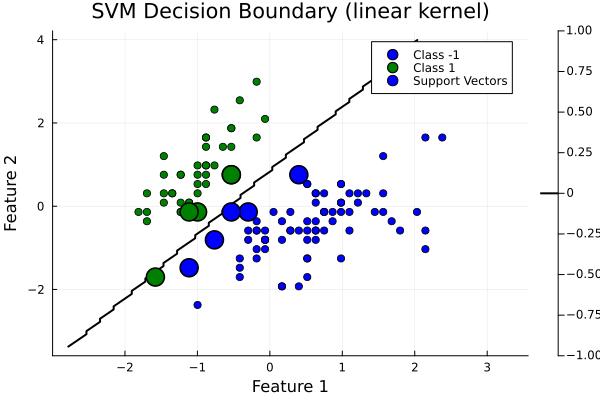

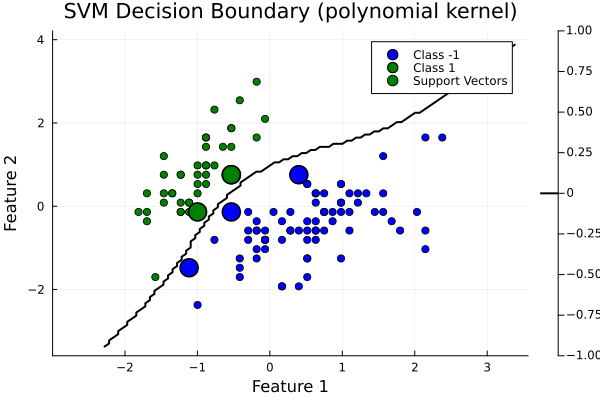

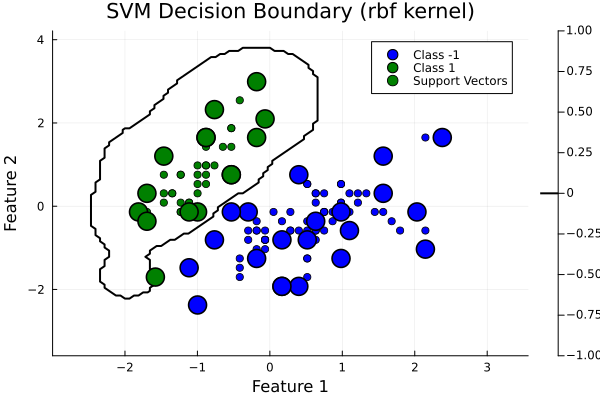

In [5]:
# Training parameters
C = 1.0
kernel_types = ["linear", "polynomial", "rbf"]  # List of kernels to test

for kernel_type in kernel_types
    println("\nKernel Type: $kernel_type")

    if kernel_type == "polynomial"
        degree = 3  # You can vary this
        γ = nothing  # Not used for polynomial
    elseif kernel_type == "rbf"
        γ = 2.0     # You can vary this
        degree = nothing  # Not used for RBF
    else
        degree = nothing
        γ = nothing
    end

    # Train the SVM model
    α, K_train = train_svm(X_train, y_train, C, kernel_type; degree=degree, gamma=γ)

    # Compute the bias term b
    b = compute_bias(α, y_train, K_train, C)

    # Make predictions on the training set
    y_pred_train = predict_svm(α, y_train, X_train, X_train, b, kernel_type;
                               degree=degree, gamma=γ)
    

    # Calculate training accuracy
    train_accuracy = mean(y_pred_train .== y_train) * 100
    println("Training Accuracy: $train_accuracy %")

    # Make predictions on the testing set
    y_pred_test = predict_svm(α, y_train, X_train, X_test, b, kernel_type;
                              degree=degree, gamma=γ)

    # Calculate testing accuracy
    test_accuracy = mean(y_pred_test .== y_test) * 100
    println("Testing Accuracy: $test_accuracy %")

    # Plot the decision boundary
    plot_decision_boundary(α, b, X_train, y_train, kernel_type; degree=degree, gamma=γ)
end


## Multi-kernel Learning

In [6]:
include("../src/MKL/multi_kernel.jl")
include("../src/MKL/plot_mkl.jl")
using .MKL: compute_kernels, train_mkl, compute_bias, predict_mkl
using .PlotMKL: plot_mkl_decision_boundary

Iteration 1...
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Iteration 2...
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Iteration 3...
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Iteration 4...
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Iteration 5...
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Iteration 6...
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Iteration 7...
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Iteration 8...
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Iteration 9...
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Iteration 10...
Set parameter Username
Academi

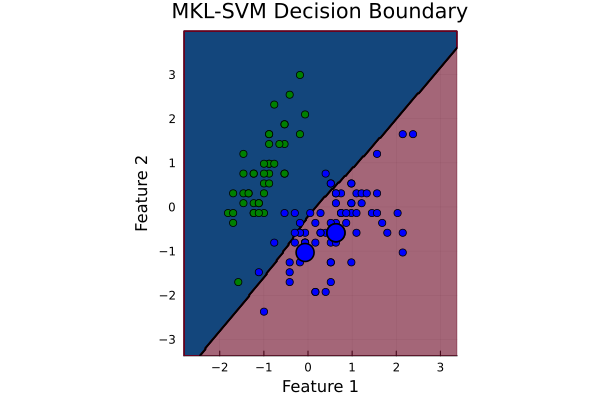

In [7]:
# Define parameters
C = 0.01
λ = 1  # Regularization for β
max_iter = 100
tolerance = 1e-3

# Define kernel specifications
kernels = [
    Dict(:type => "linear", :params => Dict()),
    Dict(:type => "polynomial", :params => Dict(:degree => 3, :c => 1.0)),
    Dict(:type => "rbf", :params => Dict(:gamma => 0.5))
]

# Compute kernels for training and test
K_list_train = compute_kernels(X_train, X_train, kernels)
K_list_test = compute_kernels(X_train, X_test, kernels)


# Train MKL-SVM
@time begin
α, β, K_combined = train_mkl(X_train, y_train, C, K_list_train, λ; max_iter=max_iter, tolerance=tolerance)
end

# Compute bias
b = compute_bias(α, y_train, K_combined, C; tolerance=tolerance)

# Predict on training and test data
y_pred_train = predict_mkl(α, y_train, X_train, X_train, β, b, K_list_train; kernel_type="precomputed", tolerance=tolerance)
y_pred_test = predict_mkl(α, y_train, X_train, X_test, β, b, K_list_test; kernel_type="precomputed", tolerance=tolerance)

# Calculate accuracies
accuracy_train = sum(y_train .== y_pred_train) / length(y_train)
accuracy_test = sum(y_test .== y_pred_test) / length(y_test)

# Print accuracies
println("Training Accuracy: ", round(accuracy_train * 100, digits=2), "%")
println("Test Accuracy: ", round(accuracy_test * 100, digits=2), "%")

# Plot decision boundary
plot_mkl_decision_boundary(α, y_train, X_train, β, b, C, kernels)

In [8]:
sum(β)

1.2554024908757497

In [9]:
sum(α)

0.8399999999995906

## Interpretable Multi Kernel Learning

In [8]:
include("../src/Interpretable_MKL/interpretable_multi_kernel.jl")
using .InterpretableMKL: sparse_optimize_beta, train_interpretable_mkl

### Reasoning for the Updated $\beta$-Optimization Step

Recall that our sparse multiple kernel learning (MKL) problem involves finding a kernel combination vector $\beta \in \mathbb{R}^q_+$ that minimizes a certain objective function subject to a sparsity constraint $\|\beta\|_0 \le k_0$. After fixing the dual variables $\alpha$, and given the kernels $\{K_i\}$, we want to solve:

$$
\min_{\beta \in \mathbb{R}_+^q} \;\; \sum_{i=1}^q \biggl[ -\tfrac{1}{2}\beta_i (y \circ \alpha)^T K_i (y \circ \alpha) \biggr] \;+\; \lambda \|\beta\|_2^2
\quad \text{subject to } \|\beta\|_0 \le k_0.
$$

### Deriving the Closed-Form Without the $\ell_0$ Constraint

If we ignore the cardinality constraint $\|\beta\|_0 \le k_0$ temporarily, we can find the unconstrained minimizer by setting the gradient to zero. Each coordinate $\beta_i$ is determined by balancing the linear and quadratic terms. For each $i$:

$$
f_i(\beta_i) = \lambda \beta_i^2 - \tfrac{1}{2} \beta_i (y \circ \alpha)^T K_i (y \circ \alpha).
$$

Setting the derivative $f_i'(\beta_i)=0$:

$$
2\lambda \beta_i = (y \circ \alpha)^T K_i (y \circ \alpha)/2.
$$

Thus, the unconstrained solution for each component is:

$$
\beta_i^* = \frac{(y \circ \alpha)^T K_i (y \circ \alpha)}{4\lambda}.
$$

If we define:

$$
u_i := (y \circ \alpha)^T K_i (y \circ \alpha),
$$

then

$$
\beta_i^* = \frac{u_i}{4\lambda}.
$$

We can compute all $\beta_i^*$ easily once $\alpha$ and $y$ are fixed.

### Imposing the $\ell_0$ Constraint

Now we need to ensure that $\|\beta\|_0 \le k_0$. The optimal way to achieve this is to pick the top $k_0$ indices corresponding to the largest $\beta_i^*$ values (or equivalently the largest $u_i$). This is because choosing a larger $u_i$ results in a greater decrease in the objective.

Hence, the solution is to:

1. Compute $u_i$ for each kernel $K_i$.
2. Compute the unconstrained $\beta_i^*$.
3. Select the $k_0$ indices with the largest $\beta_i^*$.
4. Set those $\beta_i$ to $\beta_i^*$ and all others to zero.

This operation, known as the hard-thresholding operator $H_{k_0}(u)$, enforces the sparsity directly and gives:

$$
\beta_i = 
\begin{cases}
\frac{u_i}{4\lambda}, & \text{if } i \in \text{top $k_0$ indices}\\[6pt]
0, & \text{otherwise.}
\end{cases}
$$


Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Iteration 1...
Iteration 2...
Iteration 3...
Iteration 4...
Converged after 4 iterations.
  2.378017 seconds (2.28 M allocations: 177.231 MiB, 20.44% gc time, 65.39% compilation time)
K_combined_new dimensions: (8, 120)
K_combined_new dimensions: (8, 30)
Training Accuracy: 100.0%
Test Accuracy: 100.0%
K_combined_new dimensions: (8, 90000)


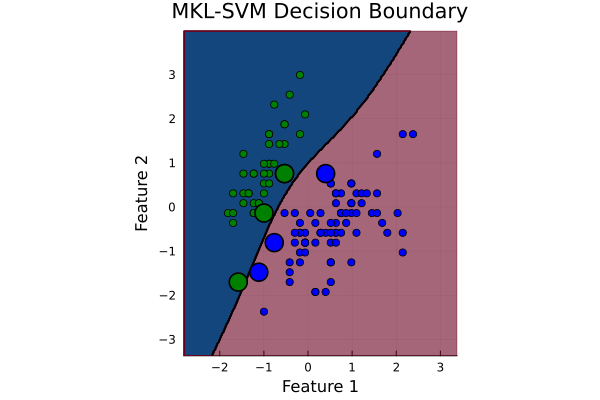

In [9]:
# Define parameters
C = 1
k0 = 3
λ = 0.1  # Regularization for β
max_iter = 50
tolerance = 1e-5

# Define kernel specifications
kernels = [
    Dict(:type => "linear", :params => Dict()),
    Dict(:type => "polynomial", :params => Dict(:degree => 3, :c => 1.0)),
    Dict(:type => "polynomial", :params => Dict(:degree => 2, :c => 1.0)),
    Dict(:type => "rbf", :params => Dict(:gamma => 0.5)),
    Dict(:type => "rbf", :params => Dict(:gamma => 0.3)),
    Dict(:type => "rbf", :params => Dict(:gamma => 0.1))
    
    
]

# Compute kernels for training and test
K_list_train = compute_kernels(X_train, X_train, kernels)
K_list_test = compute_kernels(X_train, X_test, kernels)

y_train = Float64.(y_train)
C = float(C)

# Train MKL-SVM
@time begin
    α, β, K_combined = train_interpretable_mkl(X_train, y_train, C, K_list_train, λ; max_iter=max_iter, tolerance=tolerance, k0=k0)
end

# Compute bias
b = compute_bias(α, y_train, K_combined, C; tolerance=tolerance)

# Predict on training and test data
y_pred_train = predict_mkl(α, y_train, X_train, X_train, β, b, K_list_train, kernel_type="precomputed"; tolerance=tolerance)
y_pred_test = predict_mkl(α, y_train, X_train, X_test, β, b, K_list_test, kernel_type="precomputed"; tolerance=tolerance)

# Calculate accuracies
accuracy_train = sum(y_train .== y_pred_train) / length(y_train)
accuracy_test = sum(y_test .== y_pred_test) / length(y_test)

# Print accuracies
println("Training Accuracy: ", round(accuracy_train * 100, digits=2), "%")
println("Test Accuracy: ", round(accuracy_test * 100, digits=2), "%")

# Plot decision boundary
plot_mkl_decision_boundary(α, y_train, X_train, β, b, C, kernels)

## Exploring method in Adult dataset

In [10]:
X_train, y_train, X_test, y_test = get_adult_data()

Filtered dataset summary:
Number of samples: 1628
Number of features: 5
Training set size: 1302
Testing set size: 326
Positive class ratio in training: 0.2572964669738863
Positive class ratio in testing: 0.19325153374233128


([-0.14910611838734658 1.4850900668733518 … -0.23746017624697607 1.6471304095258505; 0.1486487376560967 1.1005261712748826 … -0.23746017624697607 -0.02302557599080151; … ; 1.4141068758407307 1.1005261712748826 … -0.23746017624697607 -0.02302557599080151; 0.3719648796886792 0.7159622756764131 … -0.23746017624697607 -1.2756425651282906], [1, -1, -1, 1, -1, -1, -1, -1, -1, -1  …  -1, 1, -1, -1, 1, -1, -1, 1, 1, -1], [0.1486487376560967 1.1005261712748826 … -0.23746017624697607 2.4822084022841766; 2.0096165879276175 -2.745112784709811 … -0.23746017624697607 -2.1107205578866166; … ; 0.8930358777647049 -0.43772941111899494 … -0.23746017624697607 -0.02302557599080151; -0.2979835464090682 1.4850900668733518 … -0.23746017624697607 1.2295914131466876], [-1, -1, -1, -1, -1, -1, -1, -1, 1, -1  …  -1, -1, -1, -1, 1, -1, -1, 1, -1, 1])

In [15]:
# Define parameters
C = 1
k0 = 3
λ = 0.1  # Regularization for β
max_iter = 50
tolerance = 1e-5

# Define kernel specifications
kernels = [
    Dict(:type => "linear", :params => Dict()),
    Dict(:type => "polynomial", :params => Dict(:degree => 3, :c => 1.0)),
    Dict(:type => "polynomial", :params => Dict(:degree => 2, :c => 1.0)),
    Dict(:type => "rbf", :params => Dict(:gamma => 0.5)),
    Dict(:type => "rbf", :params => Dict(:gamma => 0.3)),
    Dict(:type => "rbf", :params => Dict(:gamma => 0.1))
    
    
]

# Compute kernels for training and test
K_list_train = compute_kernels(X_train, X_train, kernels)
K_list_test = compute_kernels(X_train, X_test, kernels)

y_train = Float64.(y_train)
C = float(C)

1.0

In [16]:
using Profile

@profile begin
    # Time the train_mkl function
    α, β, K_combined = train_interpretable_mkl(X_train, y_train, C, K_list_train, λ; max_iter=max_iter, tolerance=tolerance, k0=k0)

    # Compute bias
    b = compute_bias(α, y_train, K_combined, C; tolerance=tolerance)

    # Predict on training and test data
    y_pred_train = predict_mkl(α, y_train, X_train, X_train, β, b, K_list_train, kernel_type="precomputed"; tolerance=tolerance)
    y_pred_test = predict_mkl(α, y_train, X_train, X_test, β, b, K_list_test, kernel_type="precomputed"; tolerance=tolerance)

    # Calculate accuracies
    accuracy_train = sum(y_train .== y_pred_train) / length(y_train)
    accuracy_test = sum(y_test .== y_pred_test) / length(y_test)

    # Print accuracies
    println("Training Accuracy: ", round(accuracy_train * 100, digits=2), "%")
    println("Test Accuracy: ", round(accuracy_test * 100, digits=2), "%")
end

# Print profiling results
Profile.print()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Iteration 1...
Iteration 2...
Iteration 3...
Iteration 4...
Iteration 5...
Iteration 6...
Iteration 7...
Iteration 8...
Iteration 9...
Iteration 10...
Iteration 11...
Iteration 12...
Iteration 13...
Iteration 14...
Iteration 15...
Iteration 16...
Iteration 17...
Iteration 18...
Iteration 19...
Iteration 20...
Iteration 21...
Iteration 22...
Iteration 23...
Iteration 24...
Iteration 25...
Iteration 26...
Iteration 27...
Iteration 28...
Iteration 29...
Iteration 30...
Iteration 31...
Iteration 32...
Iteration 33...
Iteration 34...
Iteration 35...
Iteration 36...
Iteration 37...
Iteration 38...
Iteration 39...
Iteration 40...
Iteration 41...
Iteration 42...
Iteration 43...
Iteration 44...
Iteration 45...
Iteration 46...
Iteration 47...
Iteration 48...
Iteration 49...
Iteration 50...
K_combined_new dimensions: (551, 1302)
K_combined_new dimensions: (551, 326)
Training Accuracy: 83.49%
Test Accuracy: 

┌ Warning: The profile data buffer is full; profiling probably terminated
│ before your program finished. To profile for longer runs, call
│ `Profile.init()` with a larger buffer and/or larger delay.
└ @ Profile /Users/caio.iglesias/.julia/juliaup/julia-1.10.4+0.x64.apple.darwin14/share/julia/stdlib/v1.10/Profile/src/Profile.jl:609


Overhead ╎ [+additional indent] Count File:Line; Function
   90╎90     @Base/Base.jl:0; rehash!(h::OrderedCollections.OrderedDict{JuMP.Va…
     ╎1      @Base/asyncevent.jl:304; (::Base.var"#726#727"{VSCodeServer.IJulia…
     ╎ 1      @Base/asyncevent.jl:142; _trywait(t::Timer)
     ╎  1      @Base/condition.jl:125; wait
     ╎   1      @Base/condition.jl:130; wait(c::Base.GenericCondition{Base.Thre…
     ╎    1      @Base/task.jl:996; wait()
    1╎     1      @Base/libuv.jl:119; process_events
     ╎1      @Base/asyncevent.jl:306; (::Base.var"#726#727"{VSCodeServer.IJulia…
     ╎ 1      …liaCore/src/stdio.jl:243; #4
     ╎  1      …iaCore/src/stdio.jl:120; send_stdio(name::String, send_callback…
     ╎   1      …iaCore/src/stdio.jl:159; send_stream(name::String, send_callba…
     ╎    1      …c/serve_notebook.jl:78; io_send_callback(name::String, data::…
     ╎     1      …SONRPC/src/core.jl:241; send_notification(x::VSCodeServer.JS…
     ╎    ╎ 1      @JSON/src/Writer.jl:354; json
   

In [17]:
using Printf

function print_confusion_metrics(y_actual, y_pred, set_name="Data Set")
    println("---------------" * set_name * "---------------")
    println("")
    # Initialize counts
    TP = 0
    TN = 0
    FP = 0
    FN = 0

    for i in 1:length(y_actual)
        actual = y_actual[i]
        predicted = y_pred[i]
        if actual == 1 && predicted == 1
            TP += 1
        elseif actual == -1 && predicted == -1
            TN += 1
        elseif actual == -1 && predicted == 1
            FP += 1
        elseif actual == 1 && predicted == -1
            FN += 1
        end
    end

    # Print confusion matrix
    println("Confusion Matrix ($set_name):")
    println("            Predicted")
    println("            -1     +1")
    println(@sprintf("Actual -1   %-6d %-6d", TN, FP))
    println(@sprintf("       +1   %-6d %-6d", FN, TP))

    # Compute precision, recall, and F1-score
    precision = (TP + FP == 0) ? 0 : TP / (TP + FP)
    recall = (TP + FN == 0) ? 0 : TP / (TP + FN)
    f1_score = (precision + recall == 0) ? 0 : 2 * (precision * recall) / (precision + recall)

    println("Precision: ", precision)
    println("Recall: ", recall)
    println("F1-score: ", f1_score)
    println("")
end

# Example usage:
print_confusion_metrics(y_train, y_pred_train, "Train Set")
print_confusion_metrics(y_test, y_pred_test, "Test Set")

---------------Train Set---------------

Confusion Matrix (Train Set):
            Predicted
            -1     +1
Actual -1   926    41    
       +1   174    161   
Precision: 0.7970297029702971
Recall: 0.48059701492537316
F1-score: 0.5996275605214153

---------------Test Set---------------

Confusion Matrix (Test Set):
            Predicted
            -1     +1
Actual -1   252    11    
       +1   37     26    
Precision: 0.7027027027027027
Recall: 0.4126984126984127
F1-score: 0.52



### 

1. Try to use other Julia SVM solver to accelerate algorithm
2. Method 3. for proximal algorithm -> also, see what happens without it
3. Method 2 for dual ascent

## Discussions: 
1. **Normalization of betas at each iteration**: I could only make it work with it
2. **Runtime**: to run the adult dataset, I needed to sample a small part (5%) of data set and took 8min. Do we have any other ideas to speed up or is this normal? 
    - I already did some optimization on the compute_kernels code
    - Ideas: parallelize, run profiler to understand why it is taking so long, etc. 

## Next Steps

- Can be worth taking a look at this sparsePCA -> idea, maybe take out of objective and add a constraint in beta
- profiler seems to be a great idea
- look at other packages for MKL -> see if they have this scalling problem as well
- trying to figure out what optimization problem it is actually solving
- plotting/understanding relationship of lambda and norm(\beta)

## Previous Prioritized Next Steps
- Priority: 1, then 2/3 equally
- We are concerned with run-time. Try to take out gurobi as much as possible. 

1. Sparse Constraints (see trick below from class) **(DONE)**
2. Come up with universe of existing methods that we want to compare with (get papers with Nicholas)
 - Find open source implementation of their code
 - Other methods to solve the multiple kernel learning problem (can be non-sparse), e.g. L1-penalize problem - kind of similar to Lasso
 - No need to implement it
3. Reasonable dataset to test our model (can choose UCI or area I like)